# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
from math import log2

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [2]:
def gini(x):
    p = sum(x) / len(x)
    return 2 * p * (1 - p)
    
def entropy(x):
    p = sum(x) / len(x)
    return -p * log2(p) - (1 - p) * log2(1 - p)
    
def gain(left_y, right_y, criterion):
    y = np.concatenate((left_y, right_y), axis=0)
    before_split = criterion(y)
    after_split = (len(left_y) * criterion(left_y) + len(right_y) * criterion(right_y)) / len(y)
    return before_split - after_split

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [3]:
class DecisionTreeLeaf:
    def __init__(self, y):
        self.y = y

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [43]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        if criterion == 'gini':
            self.criterion = gini
        else:
            self.criterion = entropy
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def dfs(self, X, y, depth):
        if len(np.unique(y)) == 1 or len(y) <= self.min_samples_leaf or depth == self.max_depth: 
            return DecisionTreeLeaf(y)

        max_gain = -10e8
        max_split_val = None 
        max_gain_dim = None 
        for i, dim_str in enumerate(X.columns):
            dim = X[dim_str]
            split_val = np.random.choice(dim) 
            left_y = y.loc[dim < split_val]
            right_y = y.loc[dim >= split_val]
            if any(left_y) and any(right_y):
                cur_gain = gain(left_y, right_y, self.criterion)
                if cur_gain > max_gain:
                    max_gain, max_split_val, max_gain_dim, max_gain_index = cur_gain, split_val, dim_str, i    

        if not max_split_val:
            return DecisionTreeLeaf(y)
        
        left_y = y.loc[X[max_gain_dim] < max_split_val]
        left_X = X.loc[X[max_gain_dim] < max_split_val]
        left_tree = self.dfs(left_X, left_y, depth + 1)
        
        right_y = y.loc[X[max_gain_dim] >= max_split_val]
        right_X = X.loc[X[max_gain_dim] >= max_split_val]
        right_tree = self.dfs(right_X, right_y, depth + 1)
        
        return DecisionTreeNode(max_gain_index, max_split_val, left_tree, right_tree)
    
    def fit(self, X, y):
        self.root = self.dfs(X, y, 0)
        
    def predict_instance(self, cur_root, x):
        if isinstance(cur_root, DecisionTreeLeaf):
            p = sum(cur_root.y) / len(cur_root.y)
            return {1: p, 0: 1-p}
        else:
            return self.predict_instance(cur_root.left if x[cur_root.split_dim] < cur_root.split_value else cur_root.right, x)
    
    def predict_proba(self, X):
        answer = []
        for x in X.values:
            answer.append(self.predict_instance(self.root, np.array(x)))
        return answer
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [44]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [45]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

Для обоих датасетов значения метрик стали значительно лучше по сравнению с KNN. Препроцессинг тут, в общем-то, не нужен, поскольку мы смотрим относительно реальных значений в выборке на каждом сплите. Так что нормализация бы вообще ничего не изменила. Выходит, что дерево решений лучше справляется с классификацией на этих датасетах, что может быть связано с тем, что мы можем вообще не использвать "зашумляющие" фичи, т.к. всегда выбираем оптимальное свойство по количеству получаемой информации. 

In [46]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    y = y.replace({'M': 1, 'B': 0})
    return X, y

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    X = X.rename(columns={x:str(y + 1) for x,y in zip(X.columns,range(len(X.columns)))})
    return X, y

X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

In [47]:
from sklearn.metrics import accuracy_score, \
                            recall_score, precision_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

*Cancer dataset*

In [48]:
X_cancer.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [49]:
X_train, X, y_train, y = train_test_split(X_cancer, y_cancer, test_size=0.3)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5)

In [62]:
def hyperparameter_optimization(X_train, X_valid, y_train, y_valid):
    best_f1 = -1
    best_params = None
    for d in [1, 3, 5, 10, 20, 30, 50]:
        for msl in [30, 20, 15, 10, 5, 1]:
            tree = DecisionTreeClassifier(max_depth=d, min_samples_leaf=msl)
            tree.fit(X_train, y_train)
            f1 = f1_score(y_valid, tree.predict(X_valid))
            if f1 > best_f1:
                best_f1 = f1
                best_params = {'depth': d, 'min_samples_leaf': msl, 'clf': tree}
                print(f'Finished with f1-score {f1} for depth {d} and samples per leaf {msl}')
    return best_f1, best_params

In [63]:
accuracy, best_params = hyperparameter_optimization(X_train, X_valid, y_train, y_valid)
print(f'Best f1-score is {accuracy} for params: depth -- {best_params["depth"]}, min_samples_leaf -- {best_params["min_samples_leaf"]}')

Finished with f1-score 0.6101010101010101 for depth 1 and samples per leaf 30
Finished with f1-score 0.6208530805687204 for depth 1 and samples per leaf 5
Finished with f1-score 0.6740576496674058 for depth 1 and samples per leaf 1
Finished with f1-score 0.6849315068493151 for depth 3 and samples per leaf 30
Finished with f1-score 0.7509157509157509 for depth 3 and samples per leaf 15
Finished with f1-score 0.7551867219917012 for depth 3 and samples per leaf 10
Finished with f1-score 0.8101694915254237 for depth 5 and samples per leaf 30
Finished with f1-score 0.8105906313645622 for depth 5 and samples per leaf 20
Finished with f1-score 0.8137651821862347 for depth 5 and samples per leaf 15
Finished with f1-score 0.8316430020283975 for depth 5 and samples per leaf 5
Finished with f1-score 0.8384615384615386 for depth 10 and samples per leaf 15
Finished with f1-score 0.8673267326732673 for depth 10 and samples per leaf 10
Best f1-score is 0.8673267326732673 for params: depth -- 10, min_

In [64]:
tree = best_params['clf']

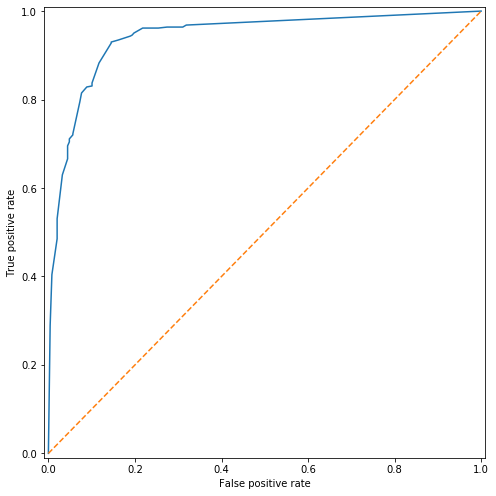

Precision: 0.8776371308016878
Recall: 0.8387096774193549
Accuracy: 0.9001447178002895


In [65]:
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)
print(f'Precision: {precision_score(y_test, tree.predict(X_test))}')
print(f'Recall: {recall_score(y_test, tree.predict(X_test))}')
print(f'Accuracy: {accuracy_score(y_test, tree.predict(X_test))}')

In [66]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Precision: 0.6951672862453532
Recall: 0.7540322580645161
Accuracy: 0.7930535455861071


*Spam dataset*

In [67]:
X_spam.head()

,1,2,3,4,5,6,7,8,9,10,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


In [68]:
y_spam.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [69]:
X_train, X, y_train, y = train_test_split(X_spam, y_spam, test_size=0.3)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5)

In [70]:
accuracy, best_params = hyperparameter_optimization(X_train, X_valid, y_train, y_valid)
print(f'Best f1-score is {accuracy} for params: depth -- {best_params["depth"]}, min_samples_leaf -- {best_params["min_samples_leaf"]}')

Finished with f1-score 0.6537717601547388 for depth 1 and samples per leaf 30
Finished with f1-score 0.6546184738955824 for depth 1 and samples per leaf 20
Finished with f1-score 0.6786703601108033 for depth 1 and samples per leaf 15
Finished with f1-score 0.7157057654075547 for depth 1 and samples per leaf 5
Finished with f1-score 0.7631578947368421 for depth 3 and samples per leaf 30
Finished with f1-score 0.802030456852792 for depth 3 and samples per leaf 20
Finished with f1-score 0.8521400778210115 for depth 5 and samples per leaf 30
Finished with f1-score 0.8571428571428572 for depth 10 and samples per leaf 15
Finished with f1-score 0.8603773584905661 for depth 10 and samples per leaf 10
Finished with f1-score 0.8796992481203008 for depth 20 and samples per leaf 15
Best f1-score is 0.8796992481203008 for params: depth -- 20, min_samples_leaf -- 15


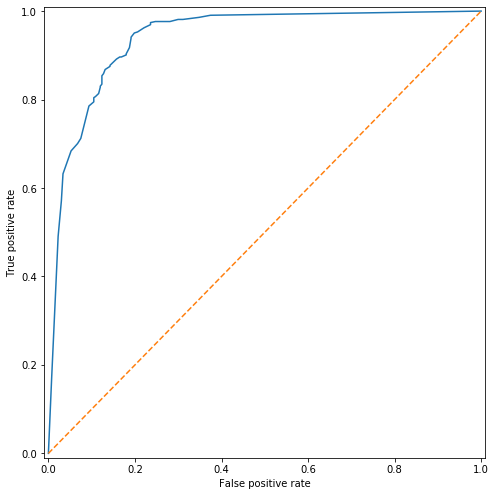

The picture is too large:(
Precision: 0.8611111111111112
Recall: 0.8127340823970037
Accuracy: 0.8769898697539797


ValueError: Image size of 49828331x3024 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 4.98283e+07x3024 with 1 Axes>

In [71]:
tree = best_params['clf']
plot_roc_curve(y_test, tree.predict_proba(X_test))
try:
    draw_tree(tree)
except Exception:
    print('The picture is too large:(')
print(f'Precision: {precision_score(y_test, tree.predict(X_test))}')
print(f'Recall: {recall_score(y_test, tree.predict(X_test))}')
print(f'Accuracy: {accuracy_score(y_test, tree.predict(X_test))}')

In [72]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Precision: 0.7306273062730627
Recall: 0.7415730337078652
Accuracy: 0.7945007235890015
